# Weighted gene co-expression network analysis

## Standard differential expression analyses seek to identify individual genes

* Each gene is treated as an individual entity
* Often misses the forest for the trees:
  * Fails to recognize that thousands of genes can be organized into relatively few modules

## Philosophy of WGCNA

* Unstand the "system" instead of reporting a list of individual parts
  * Describe the functioning of the engine instead of enumerating individual nuts and bolts
* Focus on modules/clusters as opposed to individual genes
  * the greatly alleviates multiple testing problem
* Network terminology is intutive to biologists

## Steps

* Construct a network
  * Rationale: make use of interaction patterns between genes
* Identify modules
  * Rationale: module (pathway) based analysis
* Relate modules to external information
  * Array Information: Clinical data, SNPs, proteomics
  * Gene Information: Gene ontology, EASE, IPA
  * Rationale: find biologically interesting modules
* Study Module Preservation across different data
  * Rationale：
    * Same data: to check robustness of module definition
    * Different data: to find interesting modules
* Find the key drivers in interesting modules
  * Tools: intramodular connectivity, causality testing
  * Rationale: experimental validation, therapeutics, biomarkers

### Biologically Meaningful

* reduction of high dimensional data
  * expression: microarray, RNA-seq
  * gene methylation data, fMRI data, etc.
* integration of multiscale data
  * expression data from multiple tissues
  *  SNPs (module QTL analysis)
  *  Complex phenotype

### How to construct

* Network = Adjacency Matrix
* $A=[a_{ij}]$
* A symmetric matrix with entries in [0,1]
* For unweighted netowrk, entries are 1 or 0 depending on whether or not 2 nodes are adjacent (connected)
* For weighted networks, the adjacency matrix reports the connection strength between gene pairs

### Steps for constructing a co-expression network

* Gene expression data (array or RNA-seq)
* Measure co-expression with a correlation coefficient
* The correlation matrix is either
  * dichotomized to arrive at an adjacency matrix -> unweighted network
  * OR transformed continuously with the power adjacnecy function -> weighted network

#### Two types of weighted correlation networks

* Unsigned network, absolute value
  * $a_{ij}=\left|\text{cor}(x_i,x_j)\right|^\beta$
* Signed network preserves sign info
  * $a_{ij}=\left|\cfrac{1+\text{cor}(x_i,x_j)}{2}\right|^\beta$ (min-max normalization)
  * Default values: $\beta=6$ for unsigned and $\beta=12$ for signed networks
  * Prefer unsigned network when genes with negative correlation should also be group in the same module
  * Prefer signed network when you focus on those genes with positive correlation

![fig](https://d3i71xaburhd42.cloudfront.net/00ae5e12df354c4c70b7d51863c6f9f15e44a46a/8-Figure2-1.png)

Question: 

> should network construction account for the sign of the expression relationship?

Answer:

> Overall, recent applications have convinced that signed networks are preferable

#### Why construct a co-expression network based on the correlation coefficient

1. Intuitive
2. Measuring linear relationship avoids the pitfall of overfitting
3. Because many studies have limited numbers of arrays -> hard to estimate non-linear relationships
4. Work well in practice
5. Computationally fast
6. Leads to reproducible research 

#### Why soft thresholding as opposed to hard thresholding

> Hard thresholding may lead to an information loss

1. Preserves the continuous information of the co-expression information
2. Results tend to be more robust with regard to different thresholds

#### Advantages of soft thresholding with the power function

1. Robustness: Network results are highly robust with respect to the choice of the power $\beta$
2. Calibration of different networks becomes straightforward, which facilitates consensus module analysis
3. Module preservation statistics are particularly sensitive for measuring connectivity preservation in weighted networks
4. Math resaon: Geometric Interpretation of Gene Co-Expression Network Analysis

### Choose Parameters of Adjacency Function

Question:

> How should we choose the power $\beta$ or a hard threshold? Or more generally the parameters of an adjacency function?

IDEA: 

Use properties of the connectivity distribution

Answer:

* Generalized Connectivity
  * row sum of the adjacency matrix
    * For unweighted networks: number of direct neighbors
    * For weighted networks: sum of connection strengths to other nodes
  * $k_{i}=\sum_{j}a_{ij}$
  * $p(k)$ vs $k$ in scale free networks
    * $p(k)$: proportion of nodes that have connectivity k
* Generalized Scale Free Topology
  * Motivation: using weak general assumptions, we have proven that gene co-expression networks satisfy these distributions approximately
  * Barabasi(1999): ScaleFree Topology means $\log(p(k))=c_0+c_1\log(k)$

<table>
    <tr>
        <td>
            <img src="https://www.spandidos-publications.com/article_images/ol/18/4/ol-18-04-3673-g01.jpg" width="50%">
        </td>
        <td>
            <img src="https://d3i71xaburhd42.cloudfront.net/00ae5e12df354c4c70b7d51863c6f9f15e44a46a/15-Figure4-1.png" width="1000">
        </td>
    </tr>
    <tr>
        <td>
            Scale Free Topology refers to the frequency distribution of the connectivity k
        </td>
        <td>
            The idea of check Scale Free Topology is to log transform p(k) and k and look at scatter plots.
        </td>
    </tr>
    <tr>
    <td>
        With different beta, the linear model fitting R^2 index can show different goodness of fit and thus help us to select an appropriate beta value. In practive we use the lowest value where the curve starts to "saturate". And as beta increases, the mean connectivity decreases.
    </td>
    <td>
        ...
    </td>
    </tr>
</table>

#### The scale free topology criterion for choosing the parameter values of an adjacency function

> Consider only those parameter values in the adjacency function that result in approximate scale free topology, i.e, high scale free topology fitting index $R^2$

Rationale:

* Empirical finding: Many co-expression networks based on expression data from a single tissue exhibit scale free topology
* Many other network e.g. protein-protein interaction networks have been found to exhibit scale free topology

> Caveat: When the data contains few very large modules, then the criterion may not apply. In this case, use the default choices.

In [251]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.metrics import r2_score
from itertools import combinations
from scipy.special import comb
from scipy.stats import pearsonr
from tqdm import tqdm
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.preprocessing import minmax_scale
from scipy.cluster.hierarchy import dendrogram
import sys
sys.path.append(r'C:\Users\Nature\Miniconda3\lib\site-packages\dynamicTreeCut')
from dynamicTreeCut import cutreeHybrid

In [175]:
sns.set_style("whitegrid")

In [3]:
dfrm = pd.read_csv('../lab5/all_dif_exp_data.tsv', sep='\t', index_col=0)
dfrm

,BRCA1.10,BRCA1.11,BRCA1.12,BRCA1.13,BRCA1.14,BRCA1.15,BRCA1.16,BRCA1.17,BRCA1.18,BRCA1.19,...,BRCAX.39,BRCAX.3,BRCAX.40,BRCAX.41,BRCAX.42,BRCAX.43,BRCAX.44,BRCAX.4,BRCAX.5,BRCAX.6
ensembl,,,,,,,,,,,,,,,,,,,,,
ENST00000299598,0.922576,0.823217,0.825458,0.423441,0.569902,0.880397,0.318991,0.532917,0.228809,0.359444,...,0.763862,0.486819,0.318163,0.472453,0.413418,0.656404,0.177264,0.553179,0.285378,0.382338
ENST00000610838,0.119352,0.007195,0.025261,0.345552,0.196620,0.102876,0.010329,0.021540,0.407136,0.023872,...,0.018699,0.005731,0.534973,0.997998,0.391712,0.014401,0.068232,0.258320,0.428268,0.133247
ENST00000613516,0.125112,0.005497,0.359191,0.039588,0.015730,0.002481,0.005589,0.002398,0.397964,0.007807,...,0.008921,0.005376,0.053270,0.011448,0.007161,0.012553,0.038492,0.006571,0.368886,0.016309
ENST00000610638,0.163100,0.010717,0.019344,0.021464,0.027998,0.018130,0.107411,0.005110,0.135404,0.010358,...,0.026457,0.008434,0.014699,0.009492,0.112572,0.009479,0.012339,0.005650,0.157363,0.019132
ENST00000390323,0.928931,0.005491,0.900377,0.315885,0.274099,0.871856,0.067049,0.686735,0.488145,0.048306,...,0.049243,0.280262,0.042778,0.013862,0.007741,0.035168,0.030490,0.008451,0.504480,0.029743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENST00000423997,0.022570,0.053893,0.717133,0.662860,0.036338,0.007089,0.596644,0.126552,0.449168,0.611654,...,0.054471,0.290605,0.544254,0.532919,0.478627,0.663365,0.027004,0.465514,0.249331,0.335759
ENST00000621330,0.075903,0.013561,0.150517,0.295305,0.240437,0.982901,0.057797,0.148741,0.105449,0.453365,...,0.029028,0.015428,0.103462,0.045722,0.036740,0.113700,0.156135,0.060348,0.160929,0.198248
ENST00000527152,0.098095,0.054149,0.124199,0.168484,0.212042,0.422326,0.651344,0.974933,0.506008,0.458916,...,0.799875,0.947951,0.156617,0.348248,0.196038,0.243887,0.582586,0.182810,0.135688,0.011041


In [4]:
corr_data = dfrm.T.corr(method='pearson')
corr_data.columns = dfrm.index
corr_data.index = dfrm.index

In [5]:
corr_data

ensembl,ENST00000299598,ENST00000610838,ENST00000613516,ENST00000610638,ENST00000390323,ENST00000390548,ENST00000390290,ENST00000630556,ENST00000604066,ENST00000624687,...,ENST00000510138,ENST00000438382,ENST00000605566,ENST00000442049,ENST00000629261,ENST00000423997,ENST00000621330,ENST00000527152,ENST00000576103,ENST00000612193
ensembl,,,,,,,,,,,,,,,,,,,,,
ENST00000299598,1.000000,-0.143727,-0.337743,-0.332522,0.008919,-0.233112,-0.199599,-0.277410,-0.277410,-0.185394,...,0.462739,-0.450899,0.330537,0.357468,0.265841,-0.279433,0.198579,-0.179129,0.276989,-0.464095
ENST00000610838,-0.143727,1.000000,0.187863,0.089878,0.288461,-0.038640,0.485019,0.003668,0.003668,0.169885,...,-0.266676,0.257753,-0.110168,-0.236092,-0.103290,0.141539,-0.107270,-0.040613,-0.024751,0.208300
ENST00000613516,-0.337743,0.187863,1.000000,0.375747,0.204958,0.046807,0.332624,0.053444,0.053444,0.024684,...,-0.212606,0.108551,-0.063558,-0.144632,-0.084150,0.192635,-0.119889,-0.070505,-0.015859,0.120960
ENST00000610638,-0.332522,0.089878,0.375747,1.000000,0.062261,0.186790,0.443857,0.137806,0.137806,0.009157,...,-0.132900,0.155273,-0.185142,-0.100435,0.021565,-0.051976,-0.003282,0.136605,-0.074621,0.198599
ENST00000390323,0.008919,0.288461,0.204958,0.062261,1.000000,0.117524,0.290763,0.094377,0.094377,0.048462,...,-0.117082,0.084525,-0.075597,-0.207408,-0.238942,0.016530,-0.098585,0.161779,-0.094392,-0.018162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENST00000423997,-0.279433,0.141539,0.192635,-0.051976,0.016530,-0.013701,-0.003050,-0.067014,-0.067014,0.163455,...,-0.237678,0.258926,-0.242289,-0.135558,-0.220248,1.000000,-0.173501,0.069770,0.113944,0.225482
ENST00000621330,0.198579,-0.107270,-0.119889,-0.003282,-0.098585,0.091362,-0.040016,-0.137500,-0.137500,0.007141,...,0.396565,-0.337730,0.332291,0.459159,0.625580,-0.173501,1.000000,-0.073469,0.037367,-0.347829
ENST00000527152,-0.179129,-0.040613,-0.070505,0.136605,0.161779,0.119910,0.102968,0.257533,0.257533,0.069634,...,-0.181554,0.172405,-0.071704,0.041799,-0.140995,0.069770,-0.073469,1.000000,-0.051407,0.153790


$k_i=\sum_{j}a_{ij}$

In [6]:
def power_data(power: int, x):
    return (0.5+x/2)**power

def get_connection_strengths(x):
    return x.sum()-1

def check_scale_free_topology(connection_strengths, power, bins_num=50, plot=False):
    plt.title(f"Histogram of k (power: {power}, bins: {bins_num})")
    plt.xlabel("k")
    plt.ylabel("Frequency")
    counts, bins, _ = plt.hist(connection_strengths, bins=bins_num)
    plt.show()
    X, Y = np.log10(bins[1:]), np.log10(counts/counts.sum())
    X, Y = np.array([(i,) for i in X]), np.array([(i,) for i in Y])
    regr = linear_model.LinearRegression()
    regr.fit(X,Y)
    Y_pred = regr.predict(X)
    # The coefficients # print('Coefficients: \n', regr.coef_)
    r2 = r2_score(Y, Y_pred)
    if plot:
        plt.title("Check Scale Free Topology")
        plt.xlabel("log10(k)")
        plt.ylabel("log10(p(k))")
        plt.scatter(X, Y)
        plt.plot(X, Y_pred, color='gray', linewidth=3, label="R^2: {:.2f}".format(r2))
        plt.legend()
        plt.show()
    return r2

def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

```py
plt.figure(figsize=(8,6))
plt.title(f"Histogram of k (power: {power})")
sns.distplot(connection_strengths)
```

In [7]:
def find_best_power(corr_data, start: int = 1, stop: int = 30, sep: int = 1, bins_num: int = 20):
    r2_lyst, mean_k_lyst = [], []
    for power in range(start, stop+1, sep):
        signed_corr_data = corr_data.apply(lambda x:power_data(power, x), axis=1)
        connection_strengths = signed_corr_data.apply(get_connection_strengths, axis=1)
        r2_lyst.append(check_scale_free_topology(connection_strengths, power, bins_num=bins_num, plot=False))
        mean_k_lyst.append(connection_strengths.mean())
    return r2_lyst, mean_k_lyst

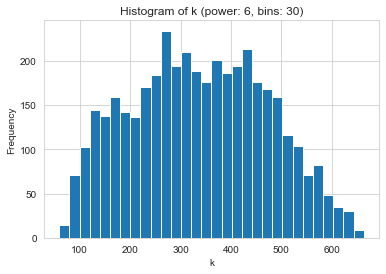

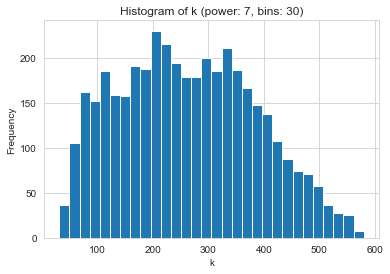

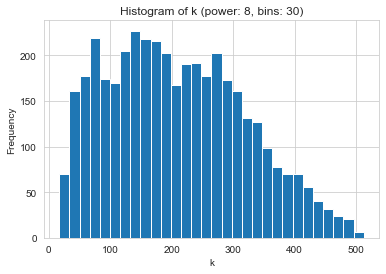

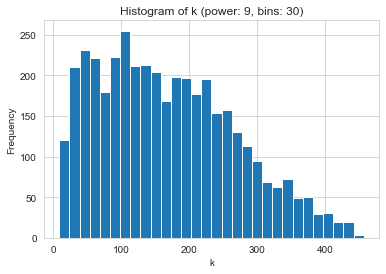

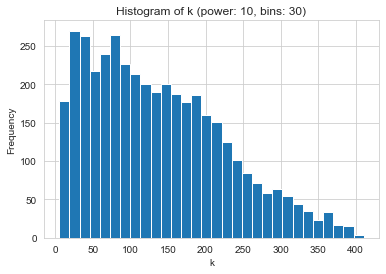

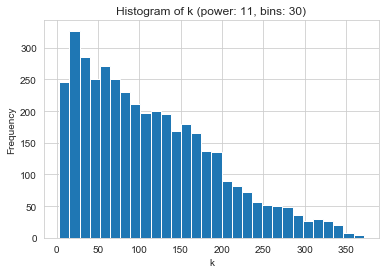

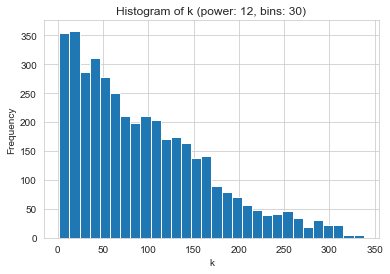

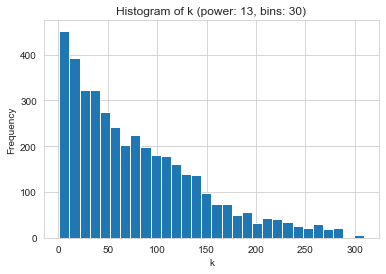

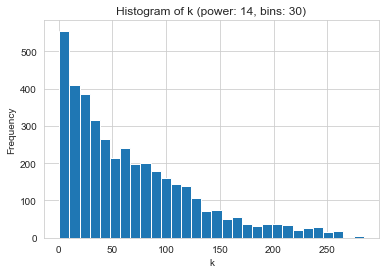

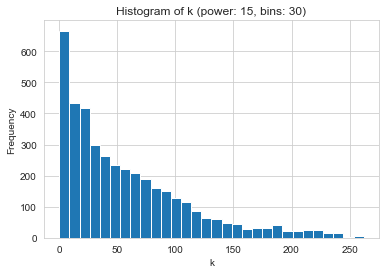

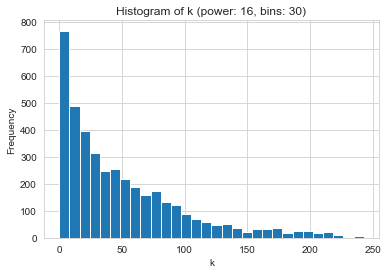

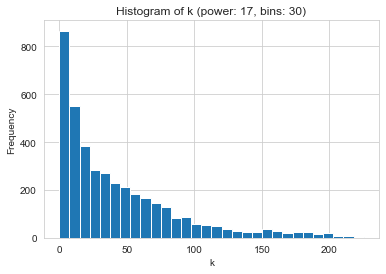

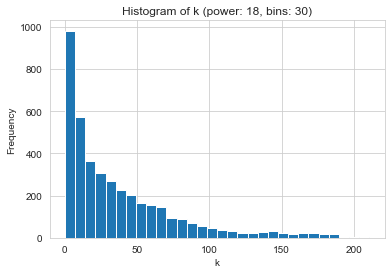

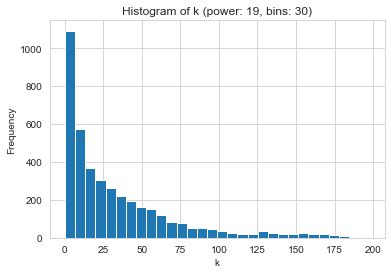

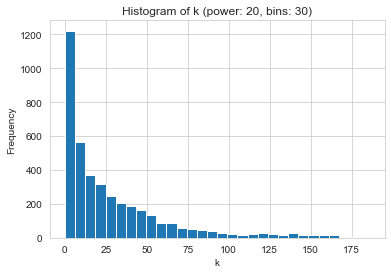

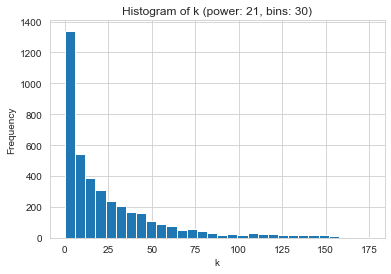

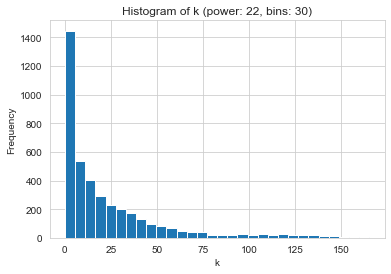

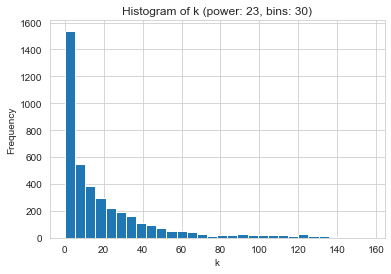

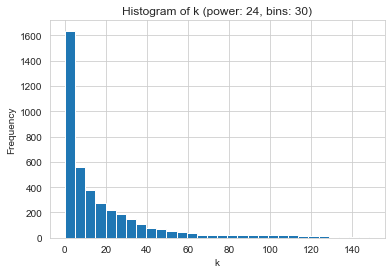

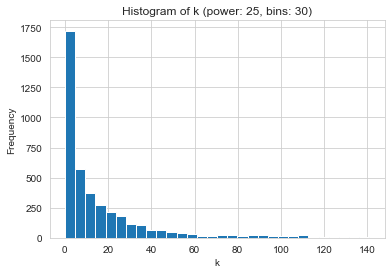

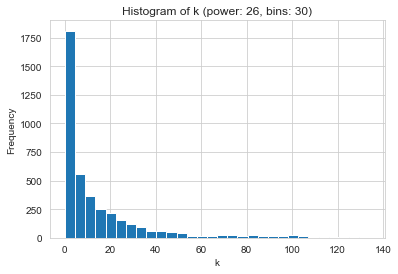

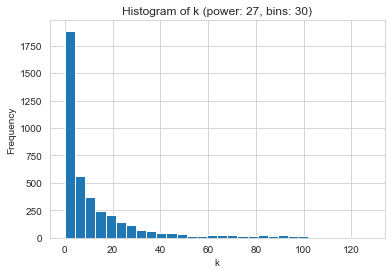

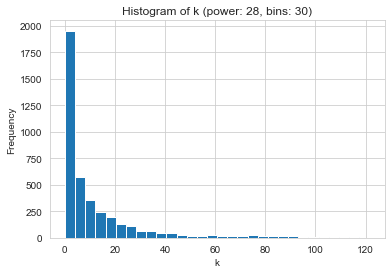

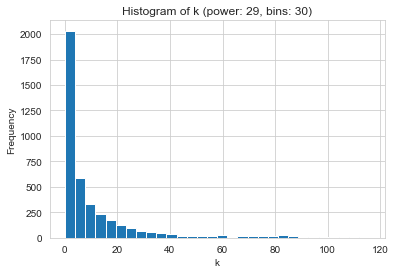

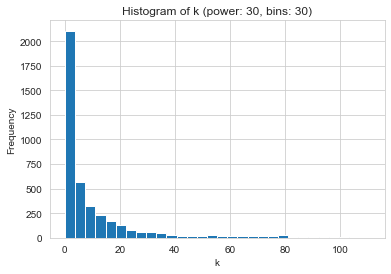

In [8]:
r2_lyst, mean_k_lyst = find_best_power(corr_data, start=6, bins_num=30)

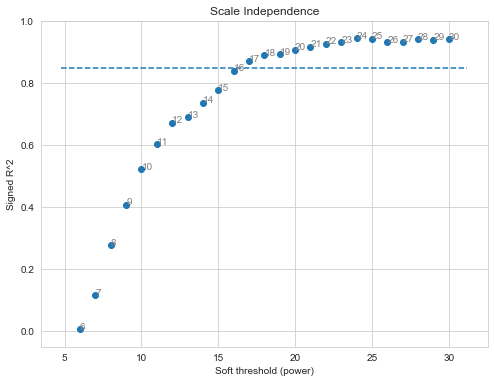

In [9]:
xs, ys = np.array(range(1, len(r2_lyst)+1))+5, r2_lyst
plt.figure(figsize=(8,6))
plt.title("Scale Independence")
plt.xlabel("Soft threshold (power)")
plt.ylabel("Signed R^2")
plt.scatter(xs, ys)
for x, y in zip(xs, ys):
    plt.text(x, y, str(x), color="gray", fontsize=10)
abline(0, 0.85)

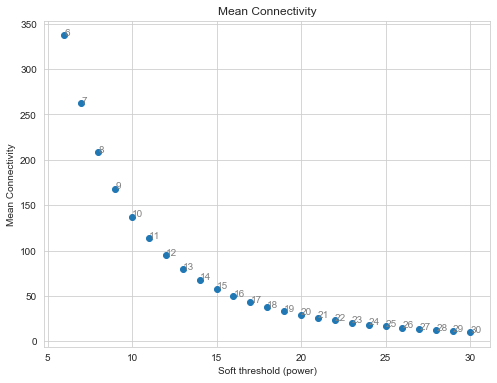

In [10]:
xs, ys = np.array(range(1, len(mean_k_lyst)+1))+5, mean_k_lyst
plt.figure(figsize=(8,6))
plt.title("Mean Connectivity")
plt.xlabel("Soft threshold (power)")
plt.ylabel("Mean Connectivity")
plt.scatter(xs, ys)
for x, y in zip(xs, ys):
    plt.text(x, y, str(x), color="gray", fontsize=10)

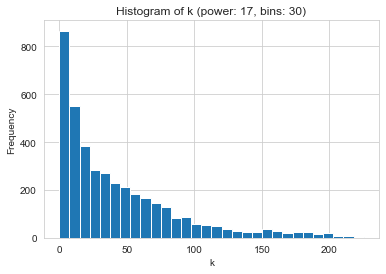

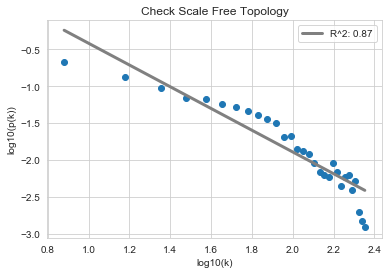

0.8712599047504079

In [11]:
power = 17
signed_corr_data = corr_data.apply(lambda x:power_data(power, x), axis=1)
connection_strengths = signed_corr_data.apply(get_connection_strengths, axis=1)
check_scale_free_topology(connection_strengths, power=power, bins_num=30, plot=True)

### Measure interconnectedness in a network

* adjacency matrix
* topological overlap matrix

#### Topological overlap matrix and corresponding dissimilarity

* $\text{TOM}_{ij}=\cfrac{\sum_{u}a_{iu}a_{uj}+a_{ij}}{\min(k_{i},k_{j})+1-a_{ij}}$
* $\text{DistTOM}_{ij}=1-\text{TOM}_{ij}$
* Generalization to weighted networks is straightforward since the formula is mathematically meaningful even if the adjacencies are real numbers in [0,1]
* Generalized topological overlap (Yip et al (2007) BMC Bioinformatics)
  * $\text{TOM}(i,j)=\cfrac{\left|N_1(i)\cup N_1(j)\right|+a_{ij}}{\min(\left|N_1(i)\right|, \left|N_1(j)\right|)+1-a_{ij}}$ for unweighted network

Noted that:

* $\sum_{u}a_{iu}a_{uj}\le\min(k_i,k_j)-a_{ij}$
* $\left|N_1(i)\cup N_1(j)\right|\le\min(\left|N_1(i)\right|, \left|N_1(j)\right|)-a_{ij}$
* $N_1(i)$ denotes the set of 1-step neighbors of node i
* $||$ measures the cardinality
* Adding 1 to the denominator prevents it from becoming 0
* Therefore, $0\le a_{ij}\le1$ implies $0\le\text{TOM}_{ij}\le1$

<table>
    <tr>
        <td><img src="https://www.researchgate.net/profile/Mohamed_Nadhir_Djekidel/post/What_do_adjacency_matrix_and_Topology_Overlap_Matrix_from_WGCNA_package_tell_about_the_data/attachment/59d6382b79197b8077995681/AS%3A396304128724992%401471497675133/download/Screen+Shot+2016-08-18+at+1.19.32+PM.png" width=50%></td>
    </tr>
</table>

### Detect Network Modules(Clusters)

#### Module Definition

* We often use average linkage hierarchical clustering coupled with the topological overlap dissimilarity measure
* Based on the resulting cluster tree, we define modules as branches
* Modules are either labeled by integers (1,2,3...) or equivalently by colors

#### Two types of branch cutting methods

* Constant height (static) cut
  * simple, but requires careful choice of height and not suitable for complicated dendrograms with nested clusters
* Adaptive (dynamic) cut
  * Two version: *Tree* and *Hybrid*
  * Both look at the shape of the branches on the dendrogram, height and size information. Small clusters can be merged with neighboring large clusters
  * *Hybrid* conbines dendrogram cutting and PAM and retains advantages of both
    * no need to specify number of cluster
    * roustness (deal with background noise)

### Visualize Network

* Topological overlap matrix plot (aka. connectivity plot)
* Multidimensional scaling (MDS)
* Heatmaps of modules
* external sortware (Traditional View):
  * ViSANT
  * Cytoscape
  * ...

<table>
  <tr>
    <td><img src="https://d3i71xaburhd42.cloudfront.net/00ae5e12df354c4c70b7d51863c6f9f15e44a46a/12-Figure3-1.png"></td>
  </tr>
  <tr>
    <td>
      Topological Overlap Plot: Modules correspond to branches of the dendrogram. <i>Since modules are sets of nodes with high topological overlap, modules correspond to red squares along the diagonal. As in all hierarchical clustering analyses, it is a judgement call where to cut the tree branches.</i>
    </td>
  </tr>
  <tr>
    <td>
      Multidimensional Scaling: Use network distance in MDS
    </td>
  </tr>
  <tr>
    <td>
      Heatmap View of Module: Since the genes of a module (rows) are highly correlated across microarray samples (columns), one observes vertical bands. The expression proﬁles are standardized across arrays. Red corresponds to high- and green to low expression values.
    </td>
  </tr>
</table>

### Summarize the expression profiles in a module

* Math Answer: Module eigengene = first principal component
* Network Answer: the most highly connected intramodular hub gene
* Both turn out to be equivalent

#### Module eigengene

> Module eigen-gene = measure of over-expression = average redness

![fig](https://media.springernature.com/full/springer-static/image/art%3A10.1186%2F1752-0509-1-54/MediaObjects/12918_2007_Article_54_Fig1_HTML.jpg?as=webp)

Using the singular value decomposition to define (module) eigengenes:

* Scale the gene expression profiles (columns)
* $\text{datX}=\text{scale}(\text{datX})$
* $\text{datX}=UDV^T$
* $U=(u_1, u_2, \ldots, u_m)$
* $V=(v_1,v_2, \dots,v_m)$
* $D=\text{diag}(\left|d_1\right|,\left|d_2\right|,\ldots,\left|d_m\right|)$
* ...

##### Usefulness

* They allow one to relate modules to each other
  * Allow one to determine whether modules should be merged
  * Or to define eigengene networks
* They allow one the relate modules to clinical traits and SNPs
  * avoids multiple comparision problem
* They allow one to define a measure of module membership: $\text{kME}=\text{cor}(x,\text{ME})$
  * kME: Module Eigengene based Connectivity
  * ME: Module Eigengene

<table>
  <tr>
    <td>
      <img src="https://image1.slideserve.com/1735790/slide38-n.jpg">
    </td>
  </tr>
  <tr>
    <td>
      Module eigengenes can be used to determine whether 2 modules are correlated. If correlation if MEs is high -> consider merging
    </td>
  </tr>
</table>

![fig](https://media.springernature.com/full/springer-static/image/art%3A10.1186%2F1752-0509-1-54/MediaObjects/12918_2007_Article_54_Fig5_HTML.jpg?as=webp)

#### Module detection in very large data sets

1. Variant of k-means to cluster variables into blocks
2. Hierarchical clustering and branch cutting in each block
3. Merge modules across blocks (based on correlations between module eigengenes)

#### Relate Modules to External Data

Clinical trait (e.g case-control status) give rise to a gene significance measure

* Abstract definition of a gene significance measure
  * GS(i) is non-negative
  * the bigger, the more "biological" significant for the i-th gene

Equivalent definition:

* $\text{GS.ClinicalTrait}(i)=\left|\text{cor}(x(i),\text{ClinicalTrait})\right|$ where x(i) is the gene expression profile of the i-th gene
* $\text{GS}(i)=\left|\text{T-test}(i)\right|$ of differetial expression between groups defined by the trait
* $\text{GS}(i)=-\log(\text{p-value})$

A gene significance naturally gives rise to a module significance measure:

* Define module significance as mean gene significance
* Often highly related to the correlation between module eigengene and trait


In [52]:
def topological_overlap(signed_corr_data, connection_strengths):
    tom = signed_corr_data.copy().values
    signed_corr_data = signed_corr_data.values
    connection_strengths = connection_strengths.values
    for i, j in tqdm(combinations(range(len(signed_corr_data)), 2), total=comb(len(signed_corr_data), 2)):
        a_ij = signed_corr_data[i][j]
        k_i = connection_strengths[i]
        k_j = connection_strengths[j]
        sum_iuj = np.dot(signed_corr_data[i], signed_corr_data[j]) - np.dot(signed_corr_data[i][[i,j]], signed_corr_data[j][[i,j]])
        res = (sum_iuj+a_ij)/(min(k_i, k_j)+1-a_ij)
        tom[i][j] = res
        # tom.loc[j, i] = res
    return tom

In [53]:
tom = topological_overlap(signed_corr_data, connection_strengths)

100%|████████████████████████| 8231653/8231653.0 [10:26<00:00, 13137.40it/s]


In [57]:
tom = np.triu(tom)
tom += tom.T - np.diag(tom.diagonal())
dis_tom = 1-tom

In [78]:
distances = pdist(dis_tom, "euclidean")
link = linkage(distances, method='average')
clusters = cutreeHybrid(link, distances)

..cutHeight not given, setting it to 6.006030192825107  ===>  99% of the (truncated) height range in dendro.
..done.


C:\Users\Nature\Miniconda3\lib\site-packages\pandas\core\series.py:1146: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


In [90]:
color_dict = dict(zip(range(1,10), sns.color_palette("husl", 9)))
row_colors = [color_dict[i] for i in clusters["labels"]]

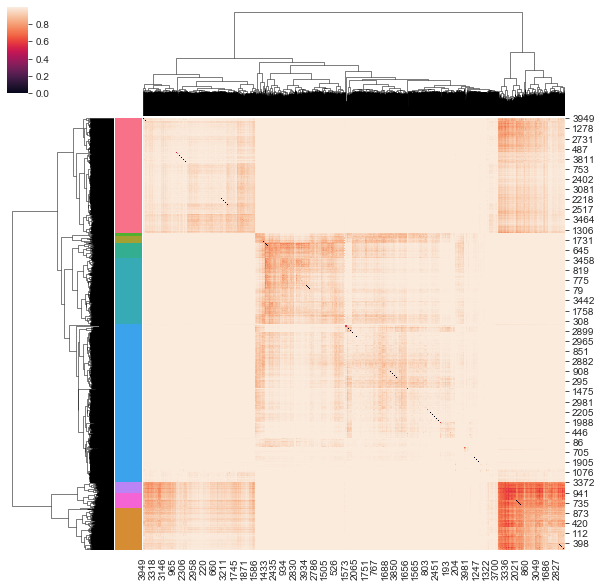

In [92]:
sns.clustermap(dis_tom, method='average', row_colors=row_colors)

In [99]:
clusters_labels = pd.Series(clusters["labels"])

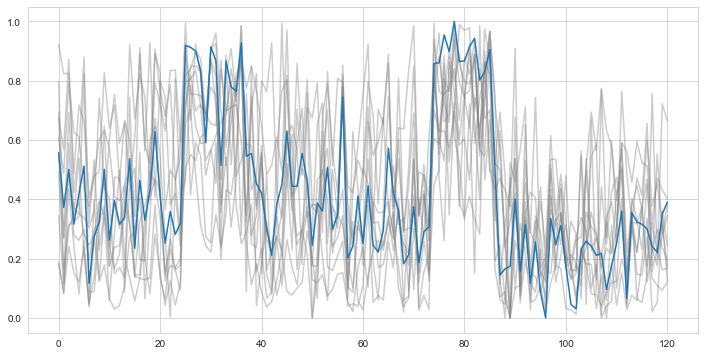

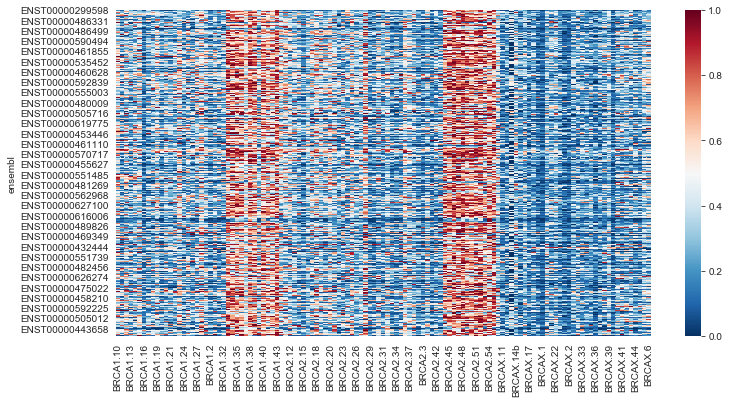

In [280]:
module_labels = tuple(range(1,10))
cur_x = tuple(range(121))
eigenGene_lyst = []
for module_label in module_labels:
    module_df = dfrm.loc[dfrm.index[clusters_labels[clusters_labels==module_label].index]]
    u, s, vh = np.linalg.svd(module_df.values)
    focus = vh[0]
    if focus.mean() < 0:
        focus = - focus
    min_max_svd_v1 = minmax_scale(focus)
    '''
    plt.figure(figsize=(12,6))
    for i in range(10):
        plt.plot(cur_x, module_df.values[i], color='gray', alpha=0.4)
    plt.plot(cur_x, min_max_svd_v1)
    plt.show()
    plt.figure(figsize=(12,6))
    sns.heatmap(module_df, cmap="RdBu_r")
    plt.show()
    
    plt.figure(figsize=(12,6))
    plt.bar(range(len(min_max_svd_v1)), height=min_max_svd_v1)
    plt.show()
    '''
    eigenGene_lyst.append(min_max_svd_v1)

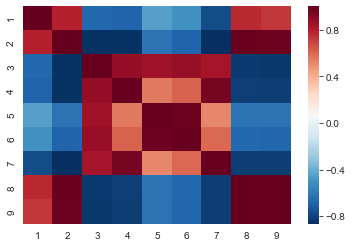

In [240]:
eigenGene_corr = pd.DataFrame(eigenGene_lyst).T.corr()
eigenGene_corr.index = range(1, 10)
eigenGene_corr.columns = range(1, 10)
sns.heatmap(eigenGene_corr, cmap="RdBu_r")

{'icoord': [[25.0, 25.0, 35.0, 35.0],
  [15.0, 15.0, 30.0, 30.0],
  [5.0, 5.0, 22.5, 22.5],
  [45.0, 45.0, 55.0, 55.0],
  [75.0, 75.0, 85.0, 85.0],
  [65.0, 65.0, 80.0, 80.0],
  [50.0, 50.0, 72.5, 72.5],
  [13.75, 13.75, 61.25, 61.25]],
 'dcoord': [[0.0, 0.04813561823046895, 0.04813561823046895, 0.0],
  [0.0, 0.08476348498950635, 0.08476348498950635, 0.04813561823046895],
  [0.0, 0.5749093457666951, 0.5749093457666951, 0.08476348498950635],
  [0.0, 0.14841634316552263, 0.14841634316552263, 0.0],
  [0.0, 0.1201943385589137, 0.1201943385589137, 0.0],
  [0.0, 0.4744202427297891, 0.4744202427297891, 0.1201943385589137],
  [0.14841634316552263,
   0.8196673113409554,
   0.8196673113409554,
   0.4744202427297891],
  [0.5749093457666951,
   4.7705578650203355,
   4.7705578650203355,
   0.8196673113409554]],
 'ivl': [1, 2, 8, 9, 5, 6, 3, 4, 7],
 'leaves': [0, 1, 7, 8, 4, 5, 2, 3, 6],
 'color_list': ['g', 'g', 'g', 'r', 'r', 'r', 'r', 'b']}

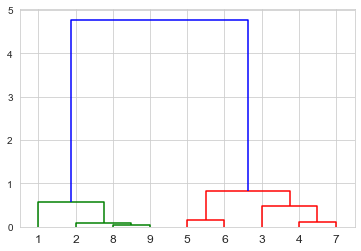

In [216]:
link = linkage(eigenGene_corr, 'average')
dendrogram(link, labels=range(1,10))

In [232]:
eigenGene_df = pd.DataFrame(eigenGene_lyst).T

In [256]:
eigenGene_df

,0,1,2,3,4,5,6,7,8
0,0.558440,0.587621,0.048901,0.063024,0.031755,0.051217,0.116950,0.466531,0.564242
1,0.372555,0.486768,0.376129,0.185851,0.456816,0.333136,0.214853,0.308932,0.375061
2,0.500953,0.818054,0.114353,0.090367,0.112904,0.100801,0.103453,0.796936,0.870450
3,0.316563,0.236230,0.233282,0.370536,0.083314,0.146088,0.463816,0.164290,0.230086
4,0.419150,0.686855,0.061446,0.096394,0.042569,0.075777,0.174450,0.657524,0.744809
...,...,...,...,...,...,...,...,...,...
116,0.300359,0.260372,0.564024,0.282336,0.771864,0.731453,0.423049,0.180985,0.181123
117,0.241430,0.094785,0.661415,0.248373,0.826292,0.793691,0.401936,0.067617,0.072260
118,0.221302,0.276384,0.524689,0.128615,0.848189,0.804645,0.305503,0.200777,0.218048
119,0.350477,0.047304,0.911346,0.722894,1.000000,1.000000,0.658197,0.032110,0.030304


In [266]:
traits = pd.DataFrame(np.random.rand(121,9))
traits.columns = [f'trait{i}' for i in range(1,10)]

In [267]:
module_trait_relation = []
for i in eigenGene_df:
    cur = [pearsonr(eigenGene_df[i], traits[j])[0] for j in traits]
    module_trait_relation.append(cur)
module_trait_relation = pd.DataFrame(module_trait_relation)
module_trait_relation.columns = traits.columns

In [274]:
?sns.clustermap

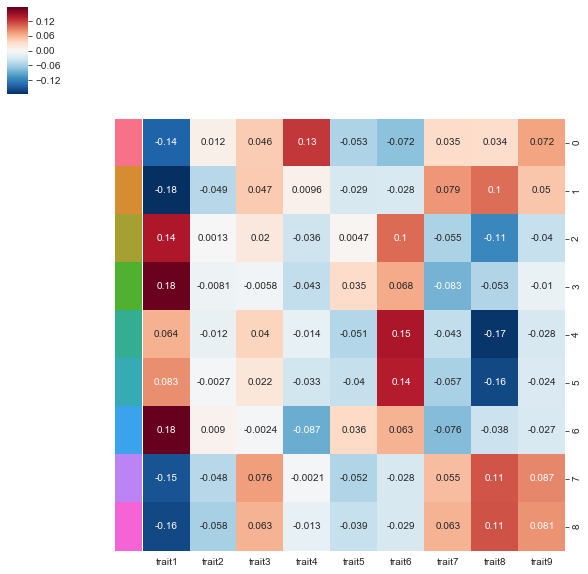

In [276]:
sns.clustermap(module_trait_relation, 
               annot=True, 
               row_colors=[color_dict[i] for i in range(1,10)], 
               row_cluster=False, 
               col_cluster=False, 
               cmap="RdBu_r")# .fig.suptitle('Module-Trait Relationship') 

### Important Task in Many Genomic Application: Given a network(pathway) of interactiong genes how to find the central players

* Connectivity can be an important variable for identifying important nodes
* Hub genes with respect to the whole network are often uninteresting (especially in coexpression networks)
  * but genes with high connectivity in interesting modules can be very interesting
* Define 2 alternative measures of intramodular connectivity for finding intramodular hubs
  * Intramodular connectivity $\text{kIN}$: Row sum across genes inside a given module: $\text{kIN}(i)=\sum_{j\in\text{ModuleSet}}a_{ij}$
    * Advantages: defined for any network based on adjacency matrix
    * Disadvantage: strong depends on module size
  * Module eigengene based connectivity $\text{kME}$ (also known as module membership measure): $\text{kME}=\text{ModuleMembership}(i)=\text{cor}(x_i,\text{ME})$
    * it is simply the correlation between i-th gene expression profile and the module eigengene
    * close to 1 means that the gene is a hub gene
    * Very useful measure for annotating gengs with regard to modules
    * Can be used to find genes that are members of two or more modules (fuzzy clustering)
    * Module eigengene can be interpreted as the most highly connected gene
* $\cfrac{\text{kIN}_{i}}{\max(\text{kIN})}\approx\left|\text{cor}(x_i,E)\right|^{\beta}=\left|\text{kME}(i)\right|^{\beta}$
  * $\left|\text{kME}(i)\right|^{\beta}$ measures group conform behavior

![fig](https://journals.plos.org/ploscompbiol/article/figure/image?size=large&id=10.1371/journal.pcbi.1000117.g008)

#### Intramodular hub genes

* Defined as genes with high kME (of high kIN)
* Single network analysis: Intramodular hubs in biologically interesting modules are often very interesting
* Differential network analysis: Genes that are intramodular hubs in one condiction but not in another are often very interesting

## Reference

1. Zhang B, Horvath S. A general framework for weighted gene co-expression network analysis. Stat Appl Genet Mol Biol. 2005;4:Article17. doi:10.2202/1544-6115.1128
2. Langfelder, P., Horvath, S. Eigengene networks for studying the relationships between co-expression modules. BMC Syst Biol 1, 54 (2007). https://doi.org/10.1186/1752-0509-1-54
3. Horvath S, Dong J. Geometric interpretation of gene coexpression network analysis. PLoS Comput Biol. 2008;4(8):e1000117. Published 2008 Aug 15. doi:10.1371/journal.pcbi.1000117